# Diffusion Validation I

#### This notebbok simulates a diffusion process in a homogenous background magnetic field. The diffusion tensor is anisotropic, meaning the parallel component is larger than the perpendicular component ($\kappa_\parallel = 10\cdot\kappa_\perp$).

Load modules and use jupyter inline magic to use interactive plots.

In [1]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare
from scipy.integrate import quad
from crpropa import *

#figure settings
A4heigth = 29.7/2.54
A4width = 21./2.54

Definition of the probability distribution function of the particle density in one dimension: <br>
$\psi(R, t) = \frac{2}{\sqrt{4 \pi D t}} \cdot \exp{-\frac{R^2}{4 D t}}$ <br>
Here, $R=||\vec{R}||$ is the norm of the position.

In [2]:
def pdf(R, t, epsilon):
    """Probability distribution function of a diffusion process.
    The diffusion coefficient is D=1e24m^2/s
    
    R - distance from injection
    t - time elapsed since injection
    epsilon - scaling for the perpendicular component
    """
    D = 1e24*epsilon
    pdf = 2 * pow(4 * np.pi * D * t, -0.5) * np.exp(- R**2. / (4 * D * t))
    return pdf

def dataCheck(df):
    """Check if all candidates are recorded 50 times."""
    cnt = df.SN.value_counts()!=50
    err = cnt[cnt==True].index.to_numpy()
    if len(err) != 0:
        print("Something went wrong!")
        print("The following serial numbers ({}) have an incomplete set of observations.".format(err))
        print("Try to rerun the simulation cell or run that part of the program outside of jupyter.")
        print("File an issue on github if the problem persists; https://github.com/CRPropa/CRPropa3/issues")

Simulation set-up <br>
Using 10000 pseudo particle to trace the phase space.

In [3]:
N = 10000

# Number of Snapshots
# used in ObserverTimeEvolution
# candidates are recorded every deltaT=2kpc/c
n = 50.
step = 100*kpc / n

# magnetic field
ConstMagVec = Vector3d(0*nG,0*nG,1*nG)
BField = UniformMagneticField(ConstMagVec)

# parameters used for field line tracking
precision = 1e-4
minStep = 0.1*pc
maxStep = 1*kpc

#ratio between parallel and perpendicular diffusion coefficient
epsilon = .1

# source settings
# A point source at the origin is isotropically injecting 10TeV protons.
source = Source()
source.add(SourcePosition(Vector3d(0.)))
source.add(SourceParticleType(nucleusId(1, 1))) 
source.add(SourceEnergy(10*TeV))
source.add(SourceIsotropicEmission())

# Output settings
# Only serial number, trajectory length and current position are stored
# The unit of length is set to kpc
Out = TextOutput('./Test.txt')
Out.disableAll()
Out.enable(Output.TrajectoryLengthColumn)
Out.enable(Output.CurrentPositionColumn)
Out.enable(Output.SerialNumberColumn)
Out.setLengthScale(kpc)

# Observer settings
Obs = Observer()
Obs.add(ObserverTimeEvolution(step, step, n))
Obs.setDeactivateOnDetection(False) # important line, as particles would be deactivated after first detection otherwise
Obs.onDetection(Out)

# Difffusion Module
# D_xx=D_yy= 1e23 m^2 / s, D_zz=10*D_xx
# The normalization is adjusted and the energy dependence is deactivated (setting power law index alpha=0)
Dif = DiffusionSDE(BField, precision, minStep, maxStep, epsilon)
Dif.setScale(1./6.1)
Dif.setAlpha(0.)


# Boundary
# Simulation ends after t=100kpc/c
maxTra = MaximumTrajectoryLength(100.0*kpc)

# module list
# Add modules to the list and run the simulation
sim = ModuleList()

sim.add(Dif)
sim.add(Obs)
sim.add(maxTra)

sim.run(source, N, True)

# Close the Output modules to flush last chunk of data to file.
Out.close()


print("Simulation finished")

Simulation finished


Load the simulation data and add a time column

In [4]:
df = pd.read_csv('Test.txt', delimiter='\t', names=["D", "SN", "X", "Y", "Z", "SN0", "SN1"], comment='#')
df['t'] = df.D * kpc / c_light #time in seconds
dataCheck(df)

#### Distribution in x, y and z
Plot the density distribution in all three coordinates.

<IPython.core.display.Javascript object>


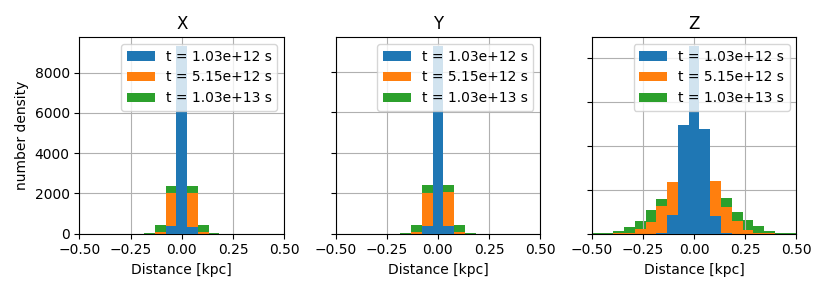

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(1.*A4width,A4heigth/4.))

coord = ['X', 'Y', 'Z']

for i, x_i in enumerate(coord):
    L = [10, 50, 100]
    for j, l in enumerate(L):
        t = l*kpc/c_light
        s = '%.2e' % t
        df[df.D==l][x_i].hist(bins=np.linspace(-0.5, 0.5, 20), ax=axes[i], label='t = '+s+' s', zorder=3-j)
    axes[i].set_title(x_i)
    axes[i].set_xlim(-0.5, 0.5)
    axes[i].legend(loc='best')
    axes[i].set_xlabel('Distance [kpc]')
    if i>0:
        axes[i].set_yticklabels([])
    else:
        axes[i].set_ylabel("number density")

plt.tight_layout()
plt.show()

${\mathrm{\bf Fig 1:}}$ Distribution of particles in three directions. Z-axis is parallel to the mean magnetic field. $\kappa_{\parallel}=100*\kappa_{\perp}$

#### Use the absolute distance from origin $|x|, |y|, |z|$ and compare to analytical expectations.

<IPython.core.display.Javascript object>


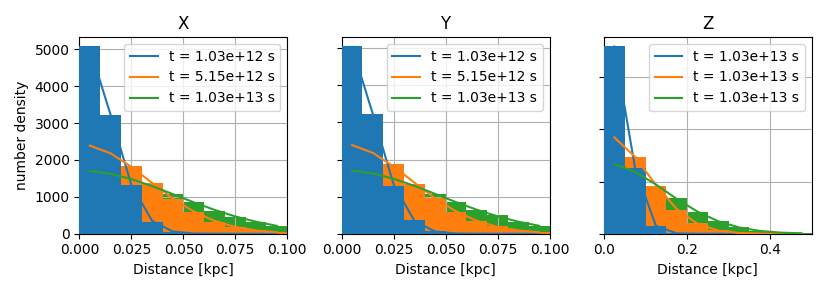

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(1.*A4width,A4heigth/4.))

coord = ['X', 'Y', 'Z']

ChiDict = {}

for i, x_i in enumerate(coord):
    ChiDict[str(x_i)] = {}
    
    L = [10, 50, 100]
    colors = sns.color_palette()
    for j, l in enumerate(L):
        ChiDict[str(x_i)][str(l)] = {}
        if i <2:
            abs(df[df.D==l][x_i]).hist(bins=np.linspace(0, 0.1, 11), ax=axes[i], alpha=1., zorder=3-j, color=colors[j])
            hist = np.histogram(abs(df[df.D==l][x_i]), bins=np.linspace(0,0.1,11))
            
            PDF = np.zeros(len(hist[0]))
            xP = np.zeros(len(hist[0]))
            for k in range(len(PDF)):
                a, b = hist[1][k]*kpc, hist[1][k+1]*kpc
                xP[k] = (a+b)/2./kpc
                PDF[k] = quad(pdf, a,b, args=(l*kpc/c_light, 0.1))[0]*N
            t = l*kpc/c_light
            s = '%.2e' % t
            axes[i].plot(xP, PDF, color=colors[j], label='t = '+s+' s', zorder=10)
            #axes[i].legend(loc='best')
            axes[i].set_xlim(0., 0.1)
        else:
            abs(df[df.D==l][x_i]).hist(bins=np.linspace(0, 0.5, 11), ax=axes[i], alpha=1., zorder=3-j, color=colors[j])
            hist = np.histogram(abs(df[df.D==l][x_i]), bins=np.linspace(0,0.5,11))
            PDF = np.zeros(len(hist[0]))
            xP = np.zeros(len(hist[0]))
            for k in range(len(PDF)):
                a, b = hist[1][k]*kpc, hist[1][k+1]*kpc
                xP[k] = (a+b)/2./kpc
                PDF[k] = quad(pdf, a,b, args=(l*kpc/c_light, 1.))[0]*N
            
            axes[i].plot(xP, PDF, color=colors[j], label='t = '+s+' s', zorder=10) 
            axes[i].set_xlim(0., 0.5)
        ChiDict[str(x_i)][str(l)]['Obs'] = hist[0]
        ChiDict[str(x_i)][str(l)]['Exp'] = PDF

        axes[i].set_xlabel('Distance [kpc]')
        axes[i].legend(loc='best')
        axes[i].set_title(x_i)
    if i>0:
        axes[i].set_yticklabels([])
    else:
         axes[i].set_ylabel("number density")
        
plt.legend()
plt.tight_layout()
plt.show()

${\mathrm{\bf Fig 2:}}$ The distance from the source position follows nicely the expected pdf.

#### Calculate the pValue of the $\chi^2$-test to prove the visual statement from above.

In [7]:
C, Time, pValue = [], [], []
for c in coord:
    for l in L:
        C.append(c)
        t = l*kpc/c_light
        s = '%.2e' % t
        Time.append(s)
        pValue.append(chisquare(ChiDict[c][str(l)]['Obs'], ChiDict[c][str(l)]['Exp'])[1])
Chi = pd.DataFrame(pValue, index = [C, Time])
Chi.rename(columns = {0:"p-Value"}, inplace=True)
Chi.index.names = ["Coordinate", "Time [s]"]
Chi

p-Value
Coordinate Time [s]          
X          1.03e+12  0.958496
           5.15e+12  0.818319
           1.03e+13  0.652841
Y          1.03e+12  0.924028
           5.15e+12  0.333872
           1.03e+13  0.573518
Z          1.03e+12  0.993620
           5.15e+12  0.607797
           1.03e+13  0.734894

${\mathrm{\bf Tab 1:}}$ The assumption that the two samles (observed and expected) are drawn from  the same distribution cannot be rejected for any direction.